# Inventory Monitoring at Distribution Centers 



## Overview

The goal of this project is to build a pipeline to process real-world, user-supplied images. 
Particularly, this project classifies a bin image by the number of objects present using 
Convolutional Neural Network (CNN). Given an inventory bin image, the algorithm will identify an 
estimate of the count of objects in the image through classification based on the Amazon Bin Image datasets the model is trained on.

• Inventory monitoring enables the maximum amount of profit from the least amount of investment in inventory without affecting customer satisfaction. Done right, it can help avoid problems, such as out-of-stock (stockout) events.



In [40]:
!pip install torch

In [2]:
!pip install torchvision

In [3]:
!pip install smdebug

In [4]:
!pip install tqdm

## Data Preparation


The cell below creates folders `train` and `test`, downloads image data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [63]:
import sagemaker

# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()

# Retrieve the sagemaker S3 bucket, region and role
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-754226678211
AWS Region: us-east-1
RoleArn: arn:aws:iam::754226678211:role/service-role/AmazonSageMaker-ExecutionRole-20220124T164987


In [ ]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data(file, data_path):
    s3_client = boto3.client('s3')

    with open(file, 'r') as f:
        d=json.load(f)
        temp = d
    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join(data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                            os.path.join(directory, file_name))
        print("Download complete")

download_and_arrange_data(file="file_list_train.json",data_path="train")  
download_and_arrange_data(file="file_list_test.json",data_path="test")

100%|██████████| 1024/1024 [01:18<00:00, 13.10it/s]


Download complete


100%|██████████| 1024/1024 [01:18<00:00, 12.97it/s]


Download complete


100%|██████████| 1024/1024 [01:18<00:00, 13.04it/s]


Download complete


100%|██████████| 1024/1024 [01:15<00:00, 13.49it/s]


Download complete


100%|██████████| 1024/1024 [01:19<00:00, 12.94it/s]


Download complete


100%|██████████| 204/204 [00:16<00:00, 12.21it/s]


Download complete


100%|██████████| 1275/1275 [01:39<00:00, 12.77it/s]


Download complete


  9%|▉         | 154/1642 [00:12<01:57, 12.61it/s]

In [15]:
with open('file_list.json', 'r') as f:
    d=json.load(f)
    for k, v in d.items():
        d.update({k:v[1024:]})
with open('file_list_test.json', 'w') as f:
    json.dump(d,f)

## Dataset


### Overview of Dataset and Inputs used

• Data can be downloaded from Amazon Open Data website https://registry.opendata.aws/amazon-bin-imagery/
• Data is captured by Amazon in their Fulfilment centre and has around 50000 images
• License
Creative Commons Attribution-NonCommercial-ShareAlike 3.0 United States (CC BY-NC-SA 3.0 US) https://creativecommons.org/licenses/by-nc-sa/3.0/us/
• Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers.
Inputs
There are two set of inputs for the model training
1. Images for the model, which is available in the source as JPEG file
Example
https://aft-vbi-pds.s3.amazonaws.com/bin-images/1005.jpg
2. JSON format with meta data for the image
Example https://aft-vbi-pds.s3.amazonaws.com/metadata/1005.json.

From the JSON file, we can filter the target label which the quantity of the objects in the image

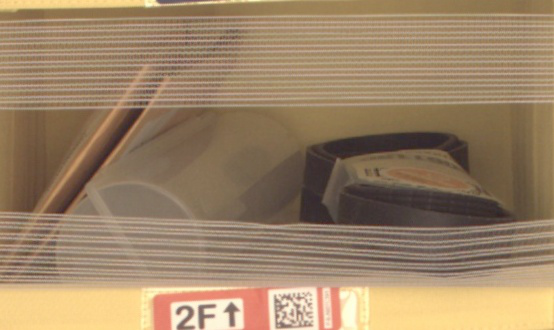

In [28]:
import requests
from PIL import Image
import io

request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/1000.jpg" }
img_bytes = requests.get(request_dict['url']).content
Image.open(io.BytesIO(img_bytes))

In [43]:
!aws s3 cp train s3://bucket/train/ --recursive

upload: train/1/00024.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00024.jpg 
upload: train/1/00009.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00009.jpg   
upload: train/1/00148.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00148.jpg   
upload: train/1/00100.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00100.jpg   
upload: train/1/00014.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00014.jpg 
upload: train/1/00088.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00088.jpg 
upload: train/1/00152.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00152.jpg 
upload: train/1/00084.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00084.jpg 
upload: train/1/00213.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00213.jpg 
upload: train/1/00237.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00237.jpg 
upload: train/1/00048.jpg to s3://sagemaker-us-east-1-754226678211/train/1/00048.jpg 
upload: train/1/00229.jpg to s3://sagemaker-us-e

In [49]:
!aws s3 cp test s3://bucket/test/ --recursive

upload: test/1/00214.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00214.jpg   
upload: test/1/00397.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00397.jpg   
upload: test/1/01006.jpg to s3://sagemaker-us-east-1-754226678211/test/1/01006.jpg   
upload: test/1/00403.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00403.jpg     
upload: test/1/00816.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00816.jpg     
upload: test/1/00672.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00672.jpg     
upload: test/1/00456.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00456.jpg   
upload: test/1/00852.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00852.jpg   
upload: test/1/01437.jpg to s3://sagemaker-us-east-1-754226678211/test/1/01437.jpg   
upload: test/1/00924.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00924.jpg   
upload: test/1/00232.jpg to s3://sagemaker-us-east-1-754226678211/test/1/00232.jpg   
upload: test/1/01239.jpg to s3://sagemaker-us-ea

## Model Training
This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [59]:
# Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values

hyperparameters = { "batch-size": 256,
                   "epochs": 10,
                   "lr": 0.05}
hyperparameters


{'batch-size': 256, 'epochs': 10, 'lr': 0.05}

In [70]:
# Create training estimator
estimator = PyTorch(
    entry_point = "train_model.py",
    base_job_name = "bin-classifier",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.2xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = f"s3://{bucket}/output/"
)

In [ ]:
# Fit estimator
train_data = f's3://{bucket}/train/'
test_data = f's3://{bucket}/test/'
estimator.fit({'train': train_data, 'test':test_data}, wait = True)

2022-02-17 19:26:20 Starting - Starting the training job...
2022-02-17 19:26:44 Starting - Preparing the instances for trainingProfilerReport-1645125979: InProgress
.........
2022-02-17 19:28:05 Downloading - Downloading input data............
2022-02-17 19:30:05 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-17 19:31:58,439 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-17 19:31:58,461 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-17 19:31:58,467 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-02-17 19:31:58,926 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
Perform hyperparameter tuning to increase the performance of your model.


In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

#Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.011),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2,14)
}

In [ ]:
# Create training estimator
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "hptuning-abid",
    role = role,
    instance_count = 5,
    instance_type = "ml.g4dn.2xlarge", #"ml.m5.large"
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = f"s3://{bucket}/hpo-output/"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type = objective_type,
)

In [ ]:
# Fit your estimator
tuner.fit({'train': train_data,
           'test': test_data}, wait = True)

In [ ]:
# Find the best hyperparameters
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters

### Model Profiling and Debugging
Using the best hyperparameters, model debugging, profiling to better monitor and debug, and finetune the model training job.
Note: You will need to use the train_model.py script to perform model profiling and debugging.

In [ ]:
#   Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, DebuggerHookConfig, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

rules = [
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "1"
    }
)

In [ ]:
#   Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='objectCountEstimator',
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters=best_hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

In [ ]:
estimator.fit({"train": train_data, "test": test_data}, wait=True) #   Your estimator here

In [ ]:
#   Plot a debugging output.
import smdebug

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
trial = smdebug.trials.create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

In [ ]:
from smdebug.core.modes import ModeKeys

len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

In [ ]:
def get_data(trial, tensor_name, mode):
    tensor = trial.tensor(tensor_name)
    steps = tensor.steps(mode=mode)
    vals = [tensor.value(s, mode=mode) for s in steps]
    return steps, vals

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output
import os

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")
!aws s3 ls {rule_output_path} --recursive

## copy to local
!aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
Deploy your model to an endpoint and then query that endpoint to get a result.

In [ ]:
model_location=estimator.model_data

In [ ]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(model_data=estimator.model_data, 
                             role=role, 
                             entry_point='inference.py', 
                             py_version='py36',
                             framework_version='1.8')


predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [ ]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")

In [ ]:
from PIL import Image
import io
import requests

def identify_bin_type(image_url):
    img_bytes = requests.get(image_url).content  #get image bytes in any format
    image = Image.open(io.BytesIO(img_bytes)) #convert bytes to file object and open
    
    buf = io.BytesIO()
    image.save(buf, format="JPEG") #convert file to jpeg BytesIO object
    response = predictor.predict(buf.getvalue()) #get the bytes from the object and pass it to the predict function
    
    return image, response

url = "https://aft-vbi-pds.s3.amazonaws.com/bin-images/777.jpg"

In [ ]:
image, _ = identify_bin_type(url)

In [ ]:
_, response = identify_bin_type(url)

In [ ]:
import numpy as np
bin_index = np.argmax(response, 1).item()
per_acc = response[0][bin_index]*100

print(f"The image contains {bin_index+1} items with a prediction accuracy of {per_acc:.2f}%")

In [ ]:
#   Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

### Cheaper Training and Cost Analysis
Perform a cost analysis of your system and then use spot instances to lessen your model training cost.

## Cost Analysis

Sagmaker vs EC2 training

### Sagemaker


### Sagemaker cost items are as follows

- GB-Mo of Training Job ML storage
- Studio-Notebook ml.t3.medium hour in US East (N. Virginia)
- Training ml.m5.xlarge hour in US East (N. Virginia)
- SageMaker Studio Notebook Instance ml.g4dn.xlarge per hour


### Overall cost for SageMaker usage - $6.20


In [ ]:
Image("sagemaker-cost.PNG")

### EC2 Model cost Items

- Amazon Elastic Compute Cloud running Linux/UNIX - Demand Linux t2.medium Instance 

- General Purpose SSD (gp2) provisioned storage

### Overall cost for SageMaker usage - $0.11

In [ ]:
Image("ec2train-cost.PNG")

#### Model training cost in EC2 is less compared to SageMaker. 
However, higher instance cost and usage will be a factor on considering the workspace 